</style>
<h1  style="text-align:center;font-size:70px">
    Challenge IOT
    <h2 style="text-align:center">
    The Geolocation Challenge
    </h2>
    <br><br>
    <h2 style="text-align:left;font-size:20px">
      <u>  Team Member : </u>
          <h3 style="text-align:left;font-size:15px">
              <blockquote>
              Sarra <br>
              Mickael Lopes  </blockquote>
          </h3>
     </h2>
</h1>

# Challenge Report

## Introduction 

The challenge is a network based location challenge based on RSSI (Received Signal Strength Indicator). 

A device send several messages at a given time to the nearest stations. Those stations records the message, with the associated signal strength, time of messages and other information.

Based on all the indications, the goal is to predict the location of the device

## Goals

The Algorithm need to show the following : 
- Build feature matrix
- Build ground truth
- Plot error cumulative probability
- Compute prediction criterion: _error @ 80%_
- Extract prediction for the test set _(Save result in csv file)_
- Build a _« leave 1 device out »_ predictor

## Data Exploration

### Librairies import and Data loading

In [1]:
# Libraries import
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
import seaborn as sns
import warnings
import datetime
import time
import os
import conda
import math

proj_lib = os.path.join('proj')
os.environ["PROJ_LIB"] = proj_lib


from geopy.distance import vincenty
from geopy.distance import geodesic
from matplotlib.patches import Circle
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.basemap import Basemap

sns.set()
warnings.filterwarnings("ignore")
%matplotlib inline

/home/mickael/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [68]:
# Load train and test data
df_mess_train = pd.read_csv('Data/mess_train_list.csv') # train set
df_mess_test = pd.read_csv('Data/mess_test_list.csv') # test set
pos_train = pd.read_csv('Data/pos_train_list.csv') # position associated to train set

In [3]:
# Utilities fonction
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

In [4]:
def calculate_initial_compass_bearing(pointA, pointB):
    """
    Calculates the bearing between two points.
    The formulae used is the following:
        θ = atan2(sin(Δlong).cos(lat2),
                  cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
    :Parameters:
      - `pointA: The tuple representing the latitude/longitude for the
        first point. Latitude and longitude must be in decimal degrees
      - `pointB: The tuple representing the latitude/longitude for the
        second point. Latitude and longitude must be in decimal degrees
    :Returns:
      The bearing in degrees
    :Returns Type:
      float
    """
    if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")

    lat1 = math.radians(pointA[0])
    lat2 = math.radians(pointB[0])

    diffLong = math.radians(pointB[1] - pointA[1])

    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)
            * math.cos(lat2) * math.cos(diffLong))

    initial_bearing = math.atan2(x, y)

    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

In [5]:
def distance(row):  
    coords_bs = (row["bs_lat"], row["bs_lng"])
    coords_dev = (row["lat"], row["lng"])
    row["geodesic_dist"] = geodesic(coords_bs, coords_dev).km
    row["bearing"] = calculate_initial_compass_bearing(coords_bs, coords_dev)
    return row

### Data Preview

Let's preview the data quickly, to see the structure of the dataset 

In [69]:
df_mess_train.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


In [7]:
df_test.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573be2503e952e191262c351,3578,116539.0,2.0,-111.0,1.463542e+12,39.728651,-105.163032
1,573c05f83e952e1912758013,2617,472504.0,0.0,-136.0,1.463551e+12,39.779908,-105.062479
2,573c05f83e952e1912758013,3556,472504.0,0.0,-127.0,1.463551e+12,39.780658,-105.053676
3,573c05f83e952e1912758013,3578,472504.0,0.0,-129.0,1.463551e+12,39.728651,-105.163032
4,573c05f83e952e1912758013,4058,472504.0,0.0,-105.0,1.463551e+12,39.783211,-105.088747


In [8]:
pos_train.head()

,lat,lng
0,39.606690,-104.958490
1,39.606690,-104.958490
2,39.637741,-104.958554
3,39.730417,-104.968940
4,39.730417,-104.968940


In order to simplify the data visualization and engineering, we will associated the pos_train data with the df_train data

In [51]:
df_train = pd.concat([df_mess_train,pos_train], axis=1)
df_train.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917,39.606690,-104.958490
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721,39.606690,-104.958490
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827,39.637741,-104.958554
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460,39.730417,-104.968940
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216,39.730417,-104.968940


Each row of the dataset represents a message (an IP packet) send from a device (identified by did) to base station (identified by bsid). When received, the base station recorded data, which are : 
  - rssi : Received Signal Strength Indicator (dbm)
  - nseq : Packet or repetition number of the messages 
  - time_ux : Time where the signal was received by the base station 

By using the messages sent by a device to several stations, our goal will to be to predict the location of the device. 
Before starting the algorith, let's explore and analyze the data in order to identify potential relationship

### Data Geo Visualization

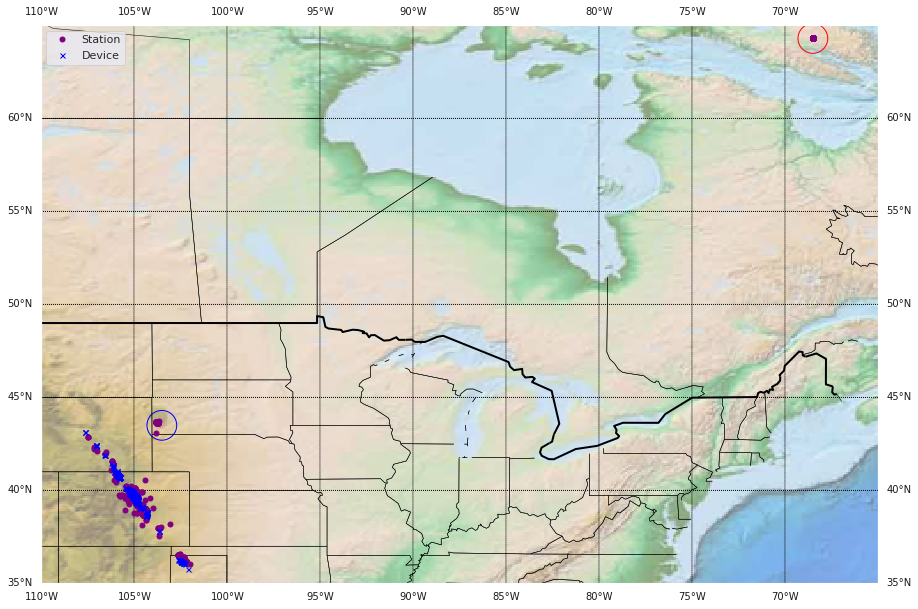

In [52]:
# Plot of device and base station on a map
fig = plt.figure(figsize=(15, 15))
m1 = Basemap(projection='cyl', resolution="l",
            lat_0=40, lon_0=-100,
           llcrnrlon=-110, llcrnrlat= 35, urcrnrlon=-65, urcrnrlat=65)

parallels = np.arange(35,65,5)
meridians = np.arange(-110,-65,5)

m1.etopo(scale = 0.7, alpha = 0.5)
m1.drawparallels(parallels,color = "black", labels = [True,True,False,False])
m1.drawmeridians(meridians,color = "black", labels = [False,False,True,True])
m1.drawstates(linewidth=0.5, color = "black")
m1.drawcountries(linewidth=2, color = "black")

# Map (long, lat) to (x, y) for plotting
xs, ys = m1(df_train["bs_lng"].values, df_train["bs_lat"].values)
xd, yd = m1(df_train["lng"].values, df_train["lat"].values)
plt.plot(xs, ys, 'ok', markersize=5, color = "purple", label = "Station")
plt.plot(xd, yd, "x", markersize = 5 , color = "blue", label = "Device")
plt.legend()

# Draw circle around the outliners
r = 0.8
x11,y11=m1(-68.5,64.3)
x12,y12 = m1(-68.5,64.3+r) 
x21,y21=m1(-103.5,43.5)
x22,y22 = m1(-103.5,43.5+r) 
circle1 = plt.Circle((x11, y11), y12-y11, color='Red',fill=False)
circle2 = plt.Circle((x21, y21), y22-y21, color='blue',fill=False)
plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)

plt.show()

We noticed 2 things in this map : 
  >- The devices location seems to follow a pattern, they seems to follow a line.
  >- There is a couple of stations far from all the others stations (circle blue and circle red on the map). We will analyze the messages received by those station because it seems strange that  those stations could received signal that far (specially for the one in the red circle).  

### Number of messages send per messid

_This metrics is interesting because the more messages is send for a given messid, the more accurate we will be able to estimate the device position._

_Moreover, for Trilateration purposes, it is more accurate to focus on stations that received equal or more than 3 messages._


Messages received by 3 station or more: 62.39 %
Messages received by less than 3 stations: 37.61 %
Messages received by one station only: 21.90 %
Average # of messages per messid: 6.47
Messages First quantile  (25%%) per messid: 2
Messages Second quantile (50%%) per messid : 3
Messages Third quantile  (75%%) per messid: 8
Max # of messages send per messid: 106


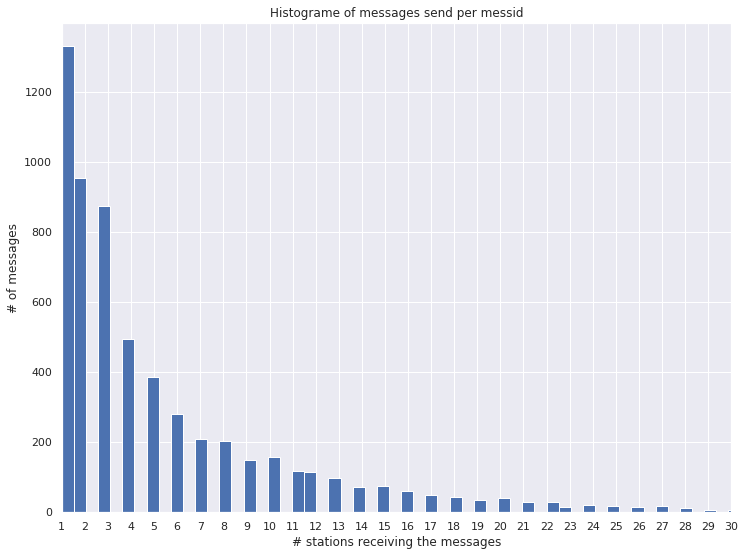

In [11]:
data = df_train.groupby("messid").count()["bsid"]
data_with_3_pos = data[data>=3].count()
data_with_3_pos_less = data[data<3].count()
data_with_1_pos = data[data==1].count()
data_descript = data.describe()
print("Messages received by 3 station or more: {0:.2f}".format(data_with_3_pos / data.count() * 100), "%")
print("Messages received by less than 3 stations: {0:.2f}".format(data_with_3_pos_less / data.count() * 100), "%")
print("Messages received by one station only: {0:.2f}".format(data_with_1_pos / data.count() * 100), "%")

print("Average # of messages per messid: {0:.2f}".format(data_descript["mean"]))
print("Messages First quantile  (25%%) per messid: {0:d}".format(int(data_descript['25%'])))
print("Messages Second quantile (50%%) per messid : {0:d}".format(int(data_descript['50%'])))
print("Messages Third quantile  (75%%) per messid: {0:d}".format(int(data_descript['75%'])))
print("Max # of messages send per messid: {0:d}".format(int(data_descript["max"])) )

plt.figure(figsize=(12,9))
plt.hist(data.values, bins= 200)
plt.xlabel("# stations receiving the messages")
plt.ylabel("# of messages")
plt.title("Histograme of messages send per messid")
plt.xlim([1, 30])
plt.xticks(np.arange(1, 30+1, 1.0))
plt.show()

__Conclusion :__

_There is a important amount of messid that are received less than 3 times (even 1 time). Therefore, it should be impossible to manage a Trilateration on this dataset. However, the preview on the data on the map show us that device follow a line. Therefore, even if we received 1 messages for a given messid, the algorithm should be able to give a position of the device on this line based on the rssi_  

### Outcast Stations

_Before going further on our data exploration and engineering, let's studies the case of the "outcast" station (red and blue circle on the Data Geo Visualization map"_

#### Explore the outcasts : part 1 
_In this part, we focus on the station located in the Red Circle of our map_
_Let's explore and see if those base stations are located nearby or far from the device._


The number of outcast station is: 27
The number of device that send messages to the outcast station is: 49
The number of messages received by those outcast station is: 4389
For those outcast station, the average distance is: 3610.63 km
For those outcast station, the average rssi indicator is: -125.30 dBm


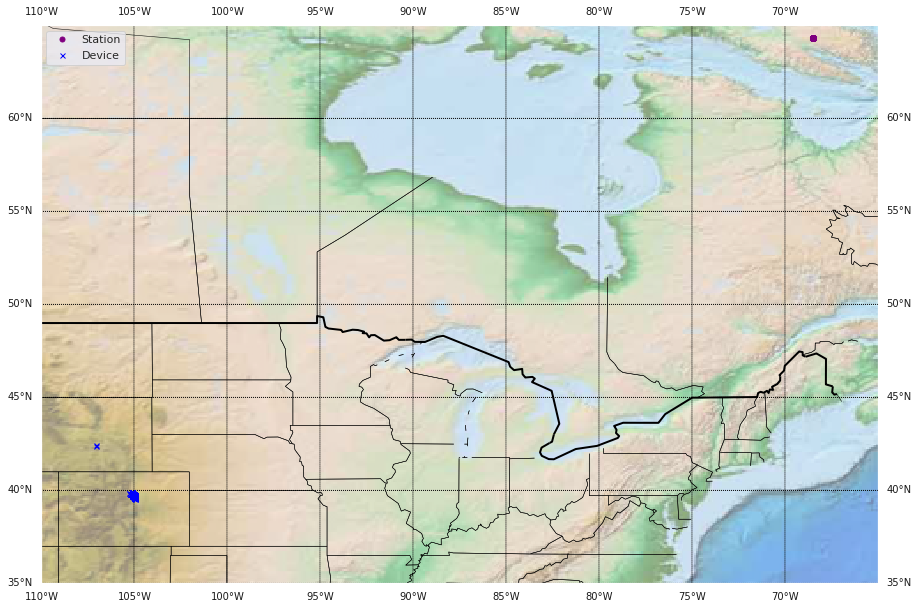

In [53]:
# Filter df_train for the messages received by the outcast stations
idx = df_train.index[df_train['bs_lat'] > 60].tolist()
df_outcast_60 = df_train.loc[idx]

# Matrix of distance between the station and the device
dist_outcast_60 = Eval_geoloc(df_outcast_60["bs_lat"] , df_outcast_60["bs_lng"], 
            df_outcast_60["lat"], df_outcast_60["lng"])
print("The number of outcast station is: {}".format(len(df_outcast_60["bsid"].unique())))
print("The number of device that send messages to the outcast station is: {}".format(len(df_outcast_60["did"].unique())))
print("The number of messages received by those outcast station is: {}".format(len(df_outcast_60)))
print("For those outcast station, the average distance is: {:.2f} km".format(np.mean(dist_outcast_60) / 1000))
print("For those outcast station, the average rssi indicator is: {:.2f} dBm".format(np.mean(df_outcast_60["rssi"])))

# Plot of device and base station on a map
fig = plt.figure(figsize=(15, 15))
m1 = Basemap(projection='cyl', resolution="l",
            lat_0=40, lon_0=-100,
           llcrnrlon=-110, llcrnrlat= 35, urcrnrlon=-65, urcrnrlat=65)

parallels = np.arange(35,65,5)
meridians = np.arange(-110,-65,5)

m1.etopo(scale = 0.7, alpha = 0.5)
m1.drawparallels(parallels,color = "black", labels = [True,True,False,False])
m1.drawmeridians(meridians,color = "black", labels = [False,False,True,True])
m1.drawstates(linewidth=0.5, color = "black")
m1.drawcountries(linewidth=2, color = "black")


# Map (long, lat) to (x, y) for plotting
xs, ys = m1(df_outcast_60["bs_lng"].values, df_outcast_60["bs_lat"].values)
xd, yd = m1(df_outcast_60["lng"].values, df_outcast_60["lat"].values)
plt.plot(xs, ys, 'ok', markersize=5, color = "purple", label = "Station")
plt.plot(xd, yd, "x", markersize = 5 , color = "blue", label = "Device")
plt.legend()
plt.show()

We leave these 5 messages for now.

Let's check if those device have send messages to other stations than the outcasts one and, if it is the case, see their average rssi.

In [54]:
device_60 = df_outcast_60["did"].unique()
station_60 = df_outcast_60["bsid"].unique()
mask_dev = (df_train["did"].isin(device_60))
mask_sta = (df_train["bsid"].isin(station_60))
df_train[mask_dev & ~mask_sta].groupby("did").agg(
    {"messid":"count", "rssi":"mean"}).rename(
    columns={"messid":"# of messages","rssi":"average Rssi"}).head(10)

,# of messages,average Rssi
did,,
473288.0,299,-129.794872
473335.0,431,-125.995746
473368.0,20,-125.083333
473507.0,419,-126.140016
473512.0,18,-123.129630
473683.0,116,-126.234195
473796.0,1214,-127.182729
473864.0,24,-127.618056
473871.0,109,-125.411315


__Conclusion:__ 

With an average distance of 3610 km between the devices and the station, and a rssi values which is not unusually low for those devices, it seems obvious there something is wrong in the dataset. Moreover, if we check the outcast stations locations, they all have the same location. 

The only possible explanation is that the latitute and longitudes given for those stations is wrong. 

It will be difficult to leave them aside (due to the number of messages received). Therefore, let's try to correct the locations of those stations.

In [55]:
# Get the messages corresponding to these 
idx = df_train.index[df_train['bs_lat'] > 60].tolist()
message_outcast_60 =  df_train.loc[idx,'messid'].unique()
# for each message, adjust the value of base lat and lng to nearest base stations by rssi value
for msg in message_outcast_60:    
    df_bymessage = df_train[df_train['messid'] == msg]
    index = df_bymessage.index[df_bymessage['bs_lat'] > 60].tolist()
    for idx in index:
    # We take the mean of the 3 nearest values
        value = df_bymessage.loc[idx,'rssi']
        tocompare = df_bymessage.iloc[(df_bymessage['rssi'] - value).abs().argsort()[1:4:]]#
        index_tocompare = tocompare.index[ tocompare['bs_lat'] < 60].tolist()
        if (len(index_tocompare)) > 0:
            v_lat = tocompare.loc[index_tocompare, 'bs_lat'].mean()        
            v_lng = tocompare.loc[index_tocompare, 'bs_lng'].mean()
            df_train.loc[idx,'bs_lat'] = v_lat
            df_train.loc[idx, 'bs_lng'] = v_lng
        else:
            df_train = df_train.drop(idx)

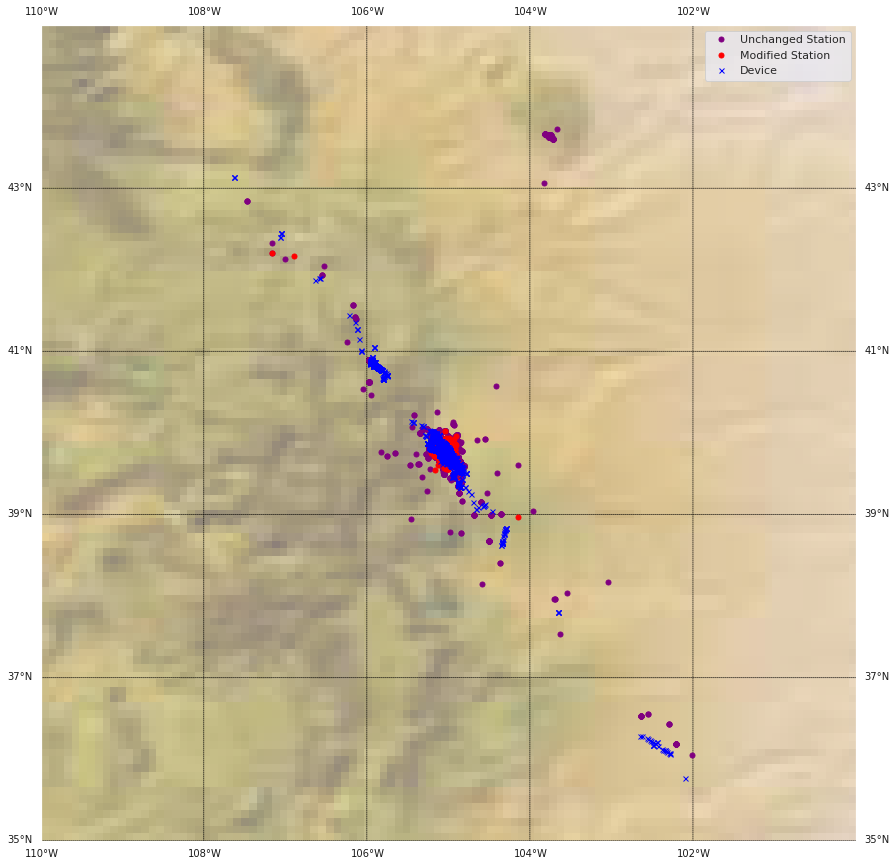

In [56]:
# Plot the new station location on the map
fig = plt.figure(figsize=(15, 15))
m2 = Basemap(projection='cyl', resolution="l",
            lat_0=40, lon_0=-100,
           llcrnrlon=-110, llcrnrlat= 35, urcrnrlon=-100, urcrnrlat=45)

parallels = np.arange(35,45,2)
meridians = np.arange(-110,-100,2)

m2.etopo(scale = 0.7, alpha = 0.5)
m2.drawparallels(parallels,color = "black", labels = [True,True,False,False])
m2.drawmeridians(meridians,color = "black", labels = [False,False,True,True])

# List of outcast station 
station_60 = df_outcast_60["bsid"].unique()
mask = df_train["bsid"].isin(station_60)

# Map (long, lat) to (x, y) for plotting
xs, ys = m2(df_train[~mask]["bs_lng"].values, df_train[~mask]["bs_lat"].values)
xs60, ys60 = m2(df_train[mask]["bs_lng"].values, df_train[mask]["bs_lat"].values)
xd, yd = m2(df_train["lng"].values, df_train["lat"].values)

plt.plot(xs, ys, 'ok', markersize=5, color = "purple", label = "Unchanged Station")
plt.plot(xs60, ys60, "ok", markersize = 5 , color = "red", label = "Modified Station")
plt.plot(xd, yd, "x", markersize = 5 , color = "blue", label = "Device")
plt.legend()

plt.show()

#### Explore the outcasts : part 2

_In this part, we focus on the station located in the blue Circle of our first map. Let's explore and see if those base stations are located nearby or far from the device._


In [57]:
idx = df_train.index[df_train['bs_lat'] > 43].tolist()
df_outcast_43 = df_train.loc[idx]
station_43 = df_outcast_43["bsid"].unique()

# Matrix of distance between the station and the device
dist_outcast_43 = Eval_geoloc(df_outcast_43["bs_lat"] , df_outcast_43["bs_lng"], 
            df_outcast_43["lat"], df_outcast_43["lng"])
print("The number of outcast station is: {}".format(len(df_outcast_43["bsid"].unique())))
print("The number of device that send messages to the outcast station is: {}".format(len(df_outcast_43["did"].unique())))
print("The number of messages received by those outcast station is: {}".format(len(df_outcast_43)))
print("For those outcast station, the average distance is: {:.2f} km".format(np.mean(dist_outcast_43) / 1000))
print("For those outcast station, the average rssi indicator is: {:.2f} dBm".format(np.mean(df_outcast_43["rssi"])))

The number of outcast station is: 10
The number of device that send messages to the outcast station is: 1
The number of messages received by those outcast station is: 178
For those outcast station, the average distance is: 441.88 km
For those outcast station, the average rssi indicator is: -133.43 dBm


If we study the rssi signal of those station (as we did in part 1), we will arrive on the same conclusion that those stations are wrongly located. Therefore, we will try to correct their position

In [58]:
device_43 = df_outcast_43['did'].unique()[0]
base_stations_corresponding = df_train[df_train['did'] == device_43]["bsid"].unique()
diff = set(base_stations_corresponding) - set(station_43)
idx1 = df_train.index[np.isin(df_train['bsid'],np.array(base_stations_corresponding))].tolist()
idx2 = df_train.index[df_train['did'] == device_43].tolist()
idx = set(idx1).intersection(set(idx2))
message_outcast_43 =  df_train.loc[idx,'messid'].unique()

for msg in message_outcast_43:    
    df_bymessage = df_train[df_train['messid'] == msg]
    index = df_bymessage.index[df_bymessage['bs_lat'] > 43].tolist()
    for idx in index:
    # We take the mean of the 3 nearest values
        value = df_bymessage.loc[idx,'rssi']
        tocompare = df_bymessage.iloc[(df_bymessage['rssi'] - value).abs().argsort()[1:4:]]
        index_tocompare = tocompare.index[ tocompare['bs_lat'] < 43].tolist()
        if (len(index_tocompare)) > 0:
            v_lat = tocompare.loc[index_tocompare, 'bs_lat'].mean()
            v_lng = tocompare.loc[index_tocompare,'bs_lng'].mean()
            df_train.loc[idx,'bs_lat'] = v_lat
            df_train.loc[idx, 'bs_lng'] = v_lng
        else:
            df_train = df_train.drop(idx)

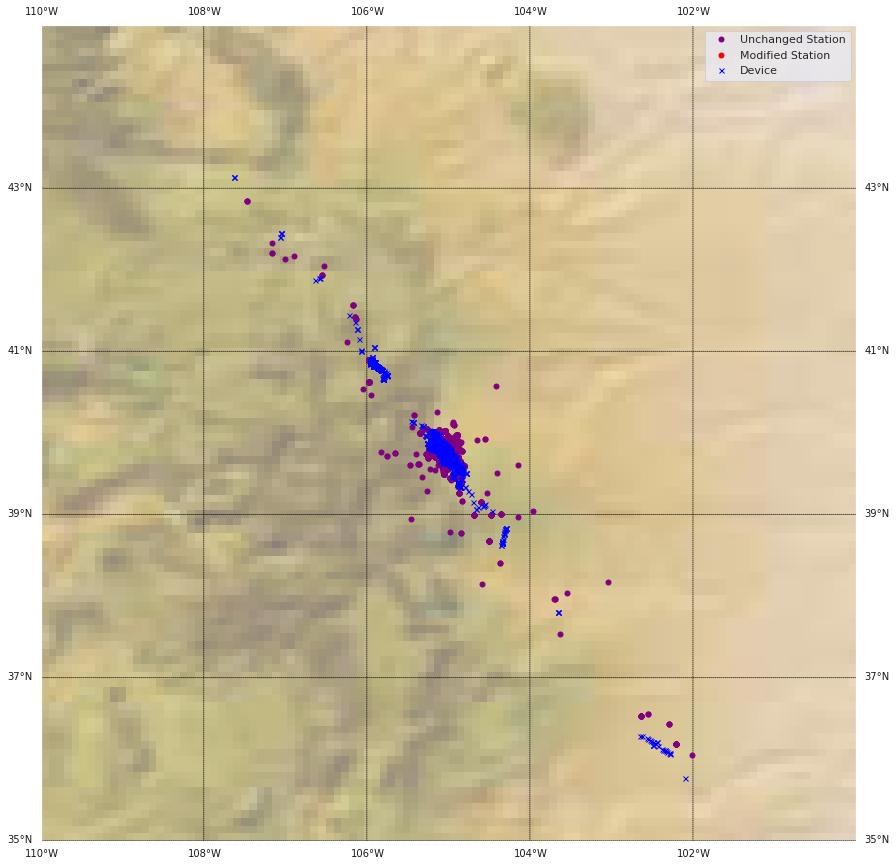

In [59]:
# Plot the new station location on the map
fig = plt.figure(figsize=(15, 15))
m2 = Basemap(projection='cyl', resolution="l",
            lat_0=40, lon_0=-100,
           llcrnrlon=-110, llcrnrlat= 35, urcrnrlon=-100, urcrnrlat=45)

parallels = np.arange(35,45,2)
meridians = np.arange(-110,-100,2)

m2.etopo(scale = 0.7, alpha = 0.5)
m2.drawparallels(parallels,color = "black", labels = [True,True,False,False])
m2.drawmeridians(meridians,color = "black", labels = [False,False,True,True])

# List of outcast station 
mask = df_train["bsid"].isin(station_43)

# Map (long, lat) to (x, y) for plotting
xs, ys = m2(df_train[~mask]["bs_lng"].values, df_train[~mask]["bs_lat"].values)
xs43, ys43 = m2(df_train[mask]["bs_lng"].values, df_train[mask]["bs_lat"].values)
xd, yd = m2(df_train["lng"].values, df_train["lat"].values)

plt.plot(xs, ys, 'ok', markersize=5, color = "purple", label = "Unchanged Station")
plt.plot(xs43, ys43, "ok", markersize = 5 , color = "red", label = "Modified Station")
plt.plot(xd, yd, "x", markersize = 5 , color = "blue", label = "Device")
plt.legend()

plt.show()

We see no "Modified station" because the algorithms find no stations with which to compare and estimate the new locaiton. Therefore we decided to drop those messages.

### Data Visualization

In [20]:
# Creation of distance matrix that will display the distance and rssi per message
dist_train = df_train.apply(distance, axis=1)
dist_train.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng,geodesic_dist,bearing
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917,39.606690,-104.958490,1.270478,193.922702
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721,39.606690,-104.958490,7.849924,183.604564
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827,39.637741,-104.958554,5.131578,57.139683
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460,39.730417,-104.968940,11.681759,130.023198
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216,39.730417,-104.968940,1.356862,306.599711


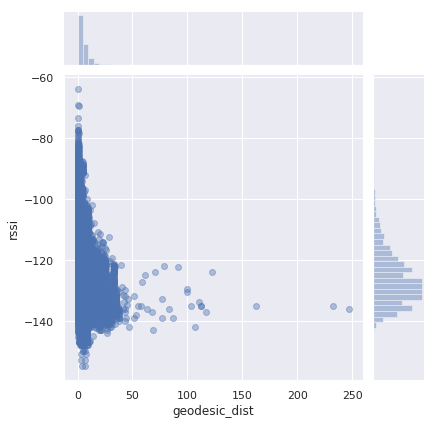

In [21]:
# Plot of the rssi with the distance
sns.jointplot(dist_train["geodesic_dist"],dist_train["rssi"], alpha = 0.4)

There some exceptional scenario between the distance and RSSI. This can be explained by several factors, such as the difference between the antenna between station (some might be more sensitive than other). To validate this hypothesis, let's pick the top 10 station that have the received the more messages and let's plot their relationship between distance and rssi. The goal will be to show that, for a given station, there is a strong relationship between rssi and distance and the direction of the signal (which will we characterized by the bearing). 

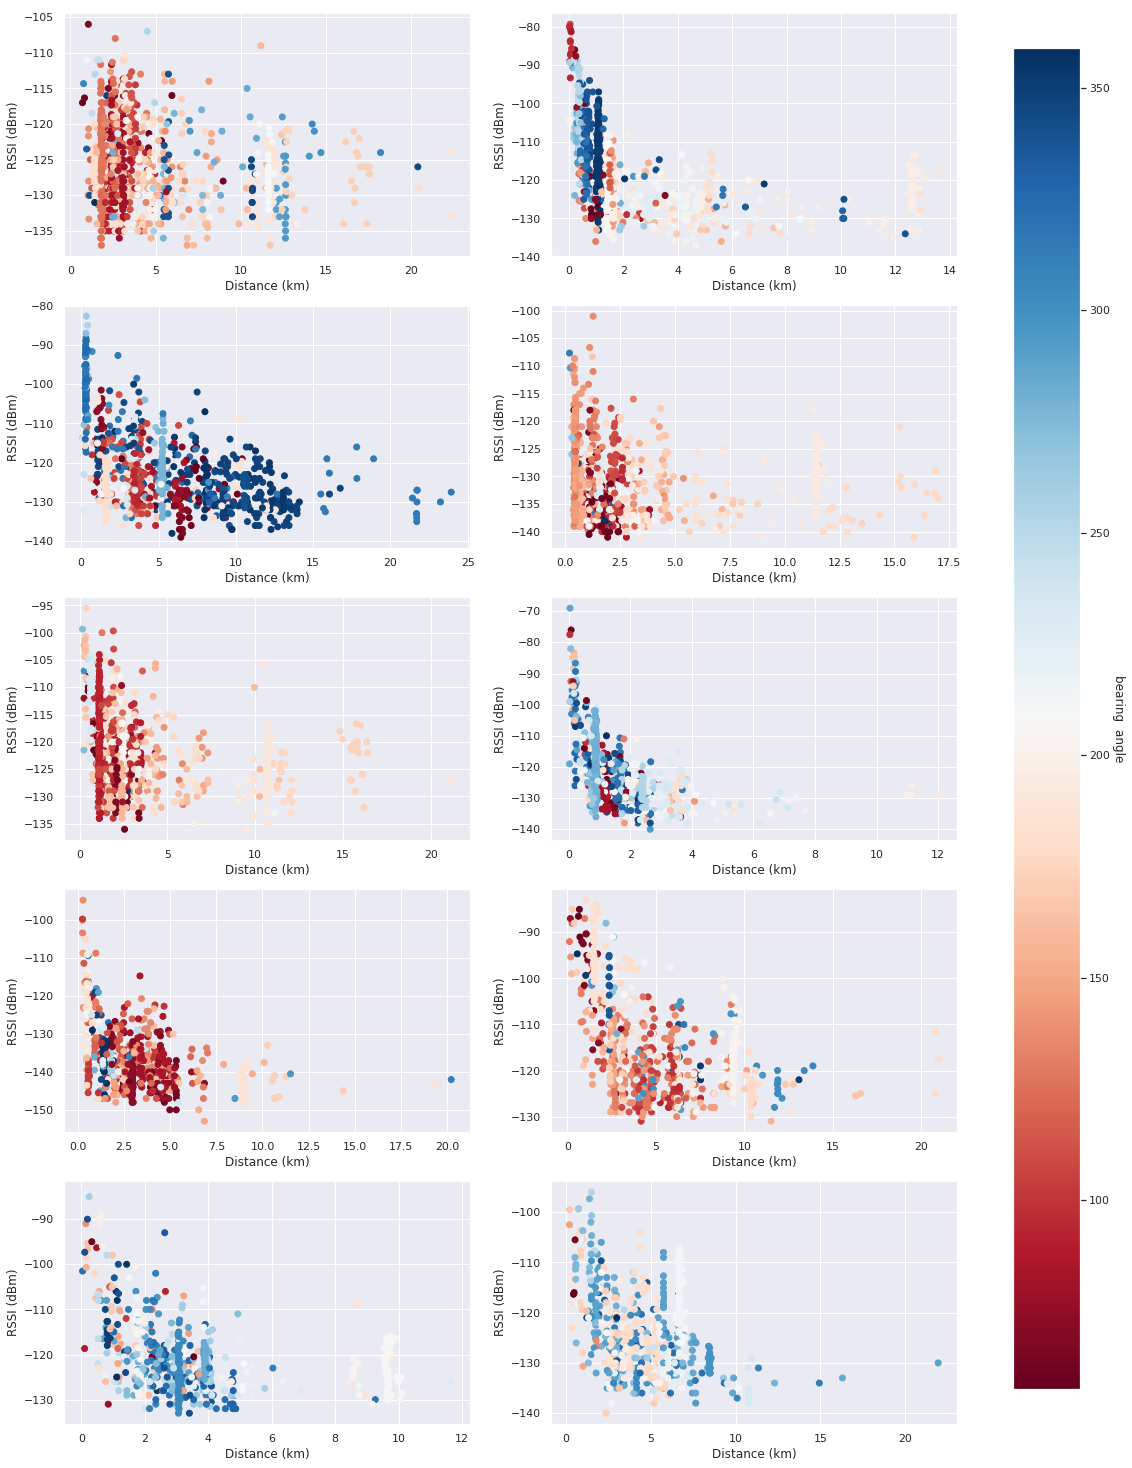

In [22]:
bsid_often = dist_train.groupby("bsid")["messid"].count().sort_values(
    ascending = False).index[:10]
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))
plt.subplots_adjust(left=None, bottom=-0.1, right=None, top=None, wspace=None, hspace=None)
i = 0
# fig.tight_layout()
# mask = dist_train["bsid"].isin(bsid_often[:10])
# heatmap = plt.gca().pcolor(dist_train[mask]["bearing"], cmap = )

for ax in axes.flat:
#     ax.set_axis_off()
    mask = dist_train["bsid"]==bsid_often[i]
    im = ax.scatter(x = dist_train[mask]["geodesic_dist"], 
           y = dist_train[mask]["rssi"], 
            c = dist_train[mask]["bearing"], cmap="RdBu")
    i +=1
    ax.set_xlabel("Distance (km)")
    ax.set_ylabel("RSSI (dBm)")

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("bearing  angle", rotation=270)
plt.show()

We can see that  for each stations, there seems to be a logarithm relationship between the rssi and the distance but there is a lot of noise in this relationship. This noise can be explained by a lot of things, such as : 
   - The device : The strenght of the signal send might be different with the device
   - The path : The signal can loss a lot of strenght depending on the path between the device and station. What can affec the signal could be walls, weather, ... 
   
However, we clearly see in each one of this station that there is strong relationship between the bearing (therefore the direction where the signal comes from) and the distance. (it is the unicolor lines that we can see in each graph). 

### Possible ameliorations
This part focus on other aspect of the data set that, we believe could been explores to improve our precision but we unfortunately did not had the time to examine

#### Time Series

By exploring the data, we notice that devices (did) reappeared several times in the dataset but with different messid. 

Our current model predict the device location indenpendantly of the previous or future messages that he sens. However, if a device send several messages in a short time intervals, it is easy to assume that its location did not vary between the messages and therefore, we could add a time series aspect to the prediction. 

#### Clustering

let's plot the messages between the station and the devices on a map

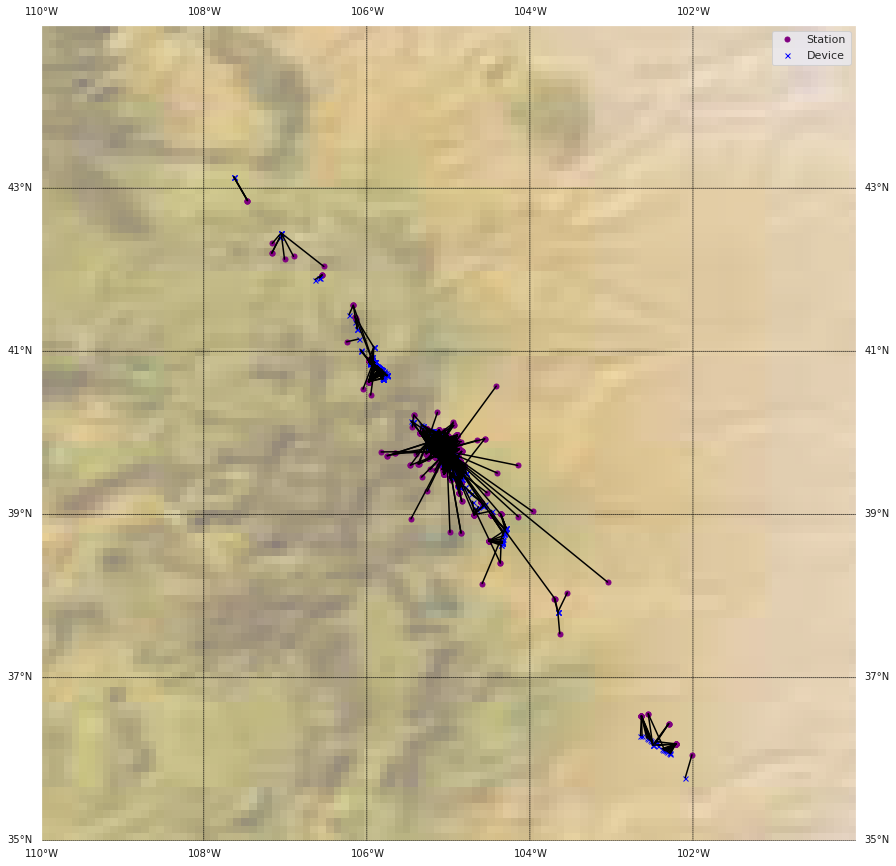

In [85]:
# Plot the new station location on the map
fig = plt.figure(figsize=(15, 15))
m2 = Basemap(projection='cyl', resolution="l",
            lat_0=40, lon_0=-100,
           llcrnrlon=-110, llcrnrlat= 35, urcrnrlon=-100, urcrnrlat=45)

parallels = np.arange(35,45,2)
meridians = np.arange(-110,-100,2)

m2.etopo(scale = 0.7, alpha = 0.5)
m2.drawparallels(parallels,color = "black", labels = [True,True,False,False])
m2.drawmeridians(meridians,color = "black", labels = [False,False,True,True])

# Map (long, lat) to (x, y) for plotting
xs, ys = df_train["bs_lng"].values, df_train["bs_lat"].values
xd, yd = df_train["lng"].values, df_train["lat"].values

plt.plot(xs, ys, 'ok', markersize=5, color = "purple", label = "Station")
plt.plot(xd, yd, "x", markersize = 5 , color = "blue", label = "Device")

n = len(xs)
for i in np.arange(n):
     plt.plot([xs[i],xd[i]], [ys[i],yd[i]], color = "black")

plt.legend()

plt.show()

We can see in this graph that the device seems to be clustered. Therefore, we could split our prediction problem by clustering the messages (depending on which station received the messages) and create a feature_matrix and prediction model for each cluster. 

## Feature Engineering

In this section, we will focus on how to highlight the features of the model.

For that, we need some methods and information :

In [26]:
# ** List of base stations both in training and in test dataset
listOfBs = np.union1d(np.unique(df_train['bsid']), np.unique(df_test['bsid'])) # determine all Base stations that received at least 1 message

### Feature Matrix

In [27]:
# ** Feature engineering based on base stations latitude and longitude **
def feature_engineering(df):
    df["rot45X"] = .707* df["bs_lng"] + .707* df["bs_lat"] 
    df["rot45Y"] = .707* df["bs_lng"] - .707* df["bs_lat"]

    df["rot30X"] = (1.732/2)* df["bs_lat"] + (1./2)* df["bs_lng"]
    df["rot30Y"] = (1.732/2)* df["bs_lng"] - (1./2)* df["bs_lat"]

    df["rot60X"] = (1./2)* df["bs_lat"] + (1.732/2)* df["bs_lng"] 
    df["rot60Y"] = (1./2)* df["bs_lng"] - (1.732/2)* df["bs_lat"]

    df["radial_r"] = np.sqrt( np.power(df["bs_lng"],2) + np.power(df["bs_lat"],2) )

Now, we try to build a feature matrix based on:

- Feature engineering of information of base station latitude and longitude
- Fingerprint method based on RSSI values by message
- The distance between a device and a base station  based on RSSI values
- The nseq values rounded 


In [29]:
# Feature Matrix construction 
def apply_on_array(a, word):
    add = lambda t: str(t) + word
    add_func = np.vectorize(add)
    result = add_func(a)
    return result

def feat_mat_const(df_mess_train, listOfBs):
    
    df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False) # group data by message (messid)
    nb_mess = len(np.unique(df_mess_train['messid']))
        
    rssi = apply_on_array(listOfBs, '_rssi')    
    # Initialize the dataframe by -200 values for RSSI matrix
    df_feat = pd.DataFrame(data = -200, index=np.arange(nb_mess) ,columns = rssi) # feature matrix
    idx = 0
    Ptx =  22
    n = 6
    # add the values of rssi for each message and within each base station
    for key, elmt in df_mess_bs_group:
        df_grouped = df_mess_bs_group.get_group(key)        
        column_bsid_rssi = apply_on_array(df_grouped['bsid'], '_rssi')
        df_feat.loc[idx, column_bsid_rssi] \
         =  df_grouped['rssi'].values 
        
        idx = idx + 1
    
    # Mean of time_ux by message
    df_feat['time_ux'] =df_mess_bs_group.mean()[['time_ux']]
    
    # Mean of base latitude by message
    df_feat['bs_lat'] = df_mess_bs_group.mean()[['bs_lat']]
    
    # Mean of base longitude by message
    df_feat['bs_lng'] = df_mess_bs_group.mean()[['bs_lng']]
    
    # Rounded mean of nseq by message
    df_feat['nseq'] = round(df_mess_bs_group.mean()[['nseq']])
    
    # Feature engineering of base station latitude and longitude
    feature_engineering(df_feat)
     
    # Distance based on RSSI mean
    RSSI = df_mess_bs_group.mean()[['rssi']]
    df_feat["d"] = 10 ** (((Ptx - RSSI)) / (10 * n))
    return df_feat

In [30]:
df_feat = feat_mat_const(df_train, listOfBs )

In [31]:
df_feat.head()

,879_rssi,911_rssi,921_rssi,944_rssi,980_rssi,1012_rssi,1086_rssi,1092_rssi,1120_rssi,1131_rssi,...,bs_lng,nseq,rot45X,rot45Y,rot30X,rot30Y,rot60X,rot60Y,radial_r,d
0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200,...,-104.953819,1.0,-46.171552,-102.233148,-18.142155,-110.713768,-71.066246,-86.811664,112.192826,263.531985
1,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200,...,-105.008827,1.0,-46.235030,-102.247451,-18.199776,-110.744016,-71.131272,-86.809050,112.232006,398.107171
2,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200,...,-105.001109,2.0,-46.131788,-102.339780,-18.076141,-110.806488,-71.055433,-86.924968,112.273680,210.001416
3,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200,...,-105.030503,1.0,-46.247428,-102.265703,-18.207030,-110.764858,-71.147973,-86.823474,112.253749,309.227264
4,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-141.0,-200.0,-200.0,-200,...,-105.033121,1.0,-46.134759,-102.382074,-18.068064,-110.848116,-71.069251,-86.965058,112.313466,292.819860


### Ground Trux Matrix

We also get the output vectors for the true device positions 

In [32]:
# ground truth construction

def ground_truth_const(df_mess_train, pos_train):
    df_mess_pos = df_mess_train.copy()
    df_mess_pos[['lat', 'lng']] = pos_train

    ground_truth_lat = np.array(df_mess_pos.groupby(['messid']).mean()['lat'])
    ground_truth_lng = np.array(df_mess_pos.groupby(['messid']).mean()['lng'])
    
    return ground_truth_lat, ground_truth_lng

In [33]:
ground_truth_lat, ground_truth_lng = ground_truth_const(df_train.iloc[:,:-3], df_train[['lat','lng']])

## Model construction

In this section, we build a model to train on the supervised data set.
We are using a machine learning algorithm based on AdaBoostRegressor with a random forest regressor.

The random forest algorithm is an algorithm easy to use and allows to tune randomized decision trees and take the average model.
The use of this algorithm can be risky as it can result in overfitting. That's why, to reduce overfitting, adaboost algorithm can be used as it adds weights into randomized decision trees, more weights to good regressors and less weight for the others.

In [35]:
# Function for training and prediction
def regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_test):
    
    # train regressor and make prediction in the train set
    # Input: df_feat: feature matrix used to train regressor
    #        ground_truth_lat: df_feat associated latitude
    #        ground_truth_lng: df_feat associated longitude
    #        df_test: data frame used for prediction
    # Output: y_pred_lat, y_pred_lng
    from sklearn import linear_model
    from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
    from sklearn.ensemble import AdaBoostRegressor
    X_train = np.array(df_feat);
    reg = AdaBoostRegressor(RandomForestRegressor(),
                            n_estimators=1000)
    reg.fit(X_train, ground_truth_lat);
    y_pred_lat = reg.predict(df_test) 

    reg.fit(X_train, ground_truth_lng);
    y_pred_lng = reg.predict(df_test) 
    
    return y_pred_lat, y_pred_lng, reg

### Apply the model on training dataset

We start by evaluating the model on all the training data set provided.

In [34]:
# Make regressor and prediction using the train set
y_pred_lat, y_pred_lng, reg = regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_feat)

Explore the importance of the features in our feature matrix.

In [35]:
importances = reg.feature_importances_
std = np.std([tree.feature_importances_ for tree in reg.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(df_feat.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, df_feat.columns[int(indices[f])], importances[indices[f]]))

Feature ranking:
1. feature radial_r (0.179806)
2. feature rot30X (0.136723)
3. feature bs_lng (0.132326)
4. feature bs_lat (0.128668)
5. feature rot60Y (0.125460)
6. feature rot45Y (0.122065)
7. feature rot30Y (0.111542)
8. feature rot60X (0.050905)
9. feature rot45X (0.003425)
10. feature time_ux (0.001907)
11. feature d (0.001149)
12. feature 4790_rssi (0.000435)
13. feature 1828_rssi (0.000434)
14. feature 1872_rssi (0.000367)
15. feature 7382_rssi (0.000320)
16. feature 4024_rssi (0.000252)
17. feature nseq (0.000196)
18. feature 8473_rssi (0.000187)
19. feature 980_rssi (0.000165)
20. feature 1859_rssi (0.000136)
21. feature 3613_rssi (0.000130)
22. feature 3526_rssi (0.000126)
23. feature 1012_rssi (0.000110)
24. feature 3629_rssi (0.000103)
25. feature 8474_rssi (0.000083)
26. feature 3572_rssi (0.000081)
27. feature 3547_rssi (0.000079)
28. feature 3386_rssi (0.000079)
29. feature 3562_rssi (0.000079)
30. feature 8245_rssi (0.000063)
31. feature 3548_rssi (0.000062)
32. featur

Let's now evaluate the precision of this model based only on the training set.

In [2001]:
err_vec = Eval_geoloc(ground_truth_lat , ground_truth_lng, y_pred_lat, y_pred_lng)
# Error criterion
print("The precision on the training set is ", np.percentile(err_vec, 80))

C:\Users\hmann\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


The precision on the training set is  652.5737025145686


We get a good estimation up to 600 meters on training set.

We can assume 

### Cross validation of the model

In [136]:
# Cross validation

In [2102]:
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
reg = AdaBoostRegressor(RandomForestRegressor(),
                            n_estimators=1000)#
y_pred_lng = cross_val_predict(reg, df_feat, ground_truth_lng, cv=10)
y_pred_lat = cross_val_predict(reg, df_feat, ground_truth_lat, cv=10)

Let's now evaluate the error, on the cross validation

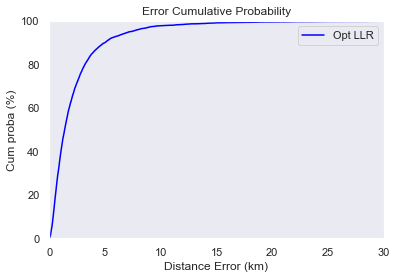

In [2106]:
# Plot error distribution
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure();
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])
plt.show()

In [2107]:
err_vec = Eval_geoloc(ground_truth_lat , ground_truth_lng, y_pred_lat, y_pred_lng)
# Error criterion
print("The precision with cross validation on the training set is ", np.percentile(err_vec, 80))

The precision with cross validation on the training set is  3224.5836482054124


C:\Users\hmann\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


We have predicted with cross validation with a precision error of  3,2km

### Construct test prediction

#### Data exploration

In [40]:
df_mess_test.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573be2503e952e191262c351,3578,116539.0,2.0,-111.0,1.463542e+12,39.728651,-105.163032
1,573c05f83e952e1912758013,2617,472504.0,0.0,-136.0,1.463551e+12,39.779908,-105.062479
2,573c05f83e952e1912758013,3556,472504.0,0.0,-127.0,1.463551e+12,39.780658,-105.053676
3,573c05f83e952e1912758013,3578,472504.0,0.0,-129.0,1.463551e+12,39.728651,-105.163032
4,573c05f83e952e1912758013,4058,472504.0,0.0,-105.0,1.463551e+12,39.783211,-105.088747


We count the number of messages sent to 3 or more station bases.

In [66]:
data = df_mess_test.groupby("messid").count()["bsid"]
data_with_3_pos = data[data>=3].count()
data_with_3_pos_less = data[data<3].count()

print("Messages sent to 3 base stations or more :" ,(data_with_3_pos / data.count() * 100), "%")
print("Messages sent to less than 3 stations : ", (data_with_3_pos_less / data.count() * 100), "%")

Messages sent to 3 base stations or more : 60.540234227427284 %
Messages sent to less than 3 stations :  39.45976577257272 %


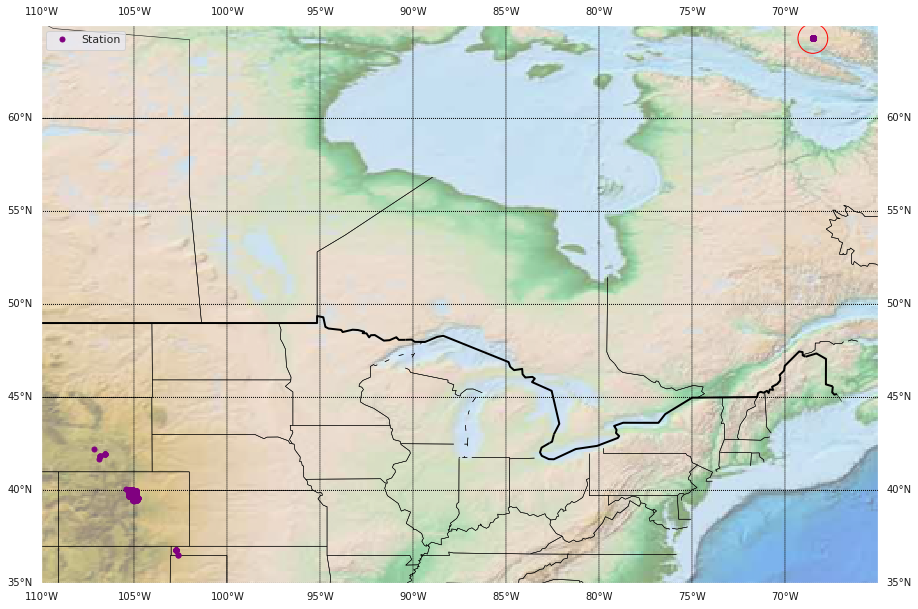

In [67]:
# Plot of station of the test set to see if there is something wrong as well
fig = plt.figure(figsize=(15, 15))
m3 = Basemap(projection='cyl', resolution="l",
            lat_0=40, lon_0=-100,
           llcrnrlon=-110, llcrnrlat= 35, urcrnrlon=-65, urcrnrlat=65)

parallels = np.arange(35,65,5)
meridians = np.arange(-110,-65,5)

m3.etopo(scale = 0.7, alpha = 0.5)
m3.drawparallels(parallels,color = "black", labels = [True,True,False,False])
m3.drawmeridians(meridians,color = "black", labels = [False,False,True,True])
m3.drawstates(linewidth=0.5, color = "black")
m3.drawcountries(linewidth=2, color = "black")

# Map (long, lat) to (x, y) for plotting
xs, ys = m3(df_mess_test["bs_lng"].values, df_mess_test["bs_lat"].values)
plt.plot(xs, ys, 'ok', markersize=5, color = "purple", label = "Station")
plt.legend()

# Draw circle around the outliners
r = 0.8
x11,y11=m1(-68.5,64.3)
x12,y12 = m1(-68.5,64.3+r) 
circle1 = plt.Circle((x11, y11), y12-y11, color='Red',fill=False)
plt.gca().add_patch(circle1)

plt.show()

We notice that there are some base stations  located very far from other base stations (red circle). Let's explore their positions and if they correspond to base stations already dealt with in the training dataset.

In [70]:
idx_60_train = df_mess_train.index[df_mess_train['bs_lat'] > 60].tolist()
base_stations_60_train = df_train.loc[idx_60_train, 'bsid']

idx_60_test = df_mess_test.index[df_mess_test['bs_lat'] > 60].tolist()
base_stations_60_test = df_mess_test.loc[idx_60_test, 'bsid']

bases_to_correct = set(base_stations_60_train) & set(base_stations_60_test)
indexes_to_correct = df_mess_test.index[df_mess_test['bsid'].isin(bases_to_correct)].tolist()

bases_outliner_60 =  df_mess_test.loc[indexes_to_correct,'bsid'].unique()
# for each message, adjust the value of base lat and lng to nearest base stations by rssi value
for base in bases_outliner_60:    
    correct_value = df_train[df_train['bsid'] == base]
    false_values_indexes = df_mess_test.index[df_mess_test['bsid'] == base].tolist()
    for idx in false_values_indexes:
        df_mess_test.loc[idx,'bs_lat'] = correct_value['bs_lat'].mean()
        df_mess_test.loc[idx,'bs_lng'] = correct_value['bs_lng'].mean()

Let's see how readjusting these values modified the locations of base stations.

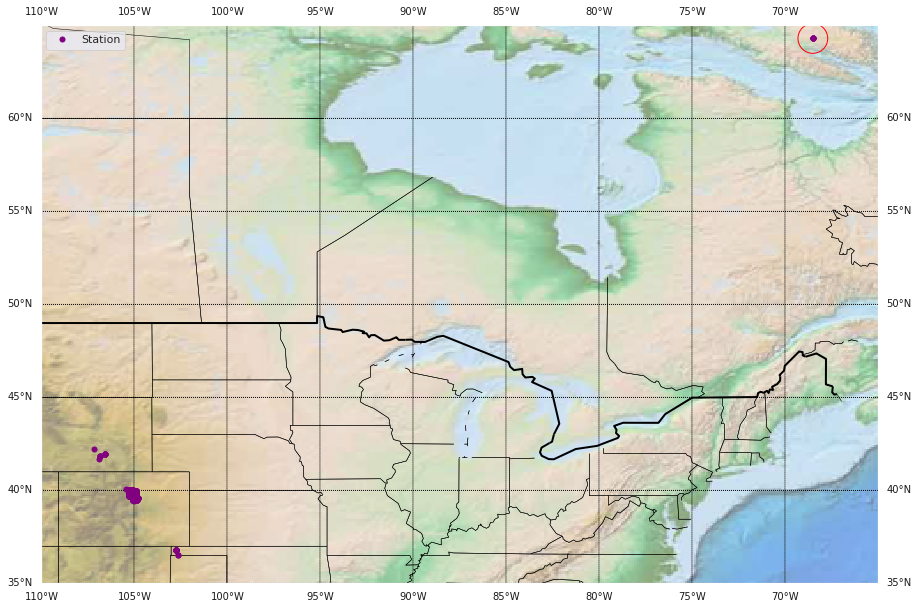

In [72]:
# Re-plot the stations of the testing set
fig = plt.figure(figsize=(15, 15))
m3 = Basemap(projection='cyl', resolution="l",
            lat_0=40, lon_0=-100,
           llcrnrlon=-110, llcrnrlat= 35, urcrnrlon=-65, urcrnrlat=65)

parallels = np.arange(35,65,5)
meridians = np.arange(-110,-65,5)

m3.etopo(scale = 0.7, alpha = 0.5)
m3.drawparallels(parallels,color = "black", labels = [True,True,False,False])
m3.drawmeridians(meridians,color = "black", labels = [False,False,True,True])
m3.drawstates(linewidth=0.5, color = "black")
m3.drawcountries(linewidth=2, color = "black")

# Map (long, lat) to (x, y) for plotting
xs, ys = m3(df_mess_test["bs_lng"].values, df_mess_test["bs_lat"].values)
plt.plot(xs, ys, 'ok', markersize=5, color = "purple", label = "Station")
plt.legend()

# Draw circle around the outliners
r = 0.8
x11,y11=m1(-68.5,64.3)
x12,y12 = m1(-68.5,64.3+r) 
circle1 = plt.Circle((x11, y11), y12-y11, color='Red',fill=False)
plt.gca().add_patch(circle1)

plt.show()

Some base stations are still very far from the others. Let's see how many and how many messages there are sent to them.

In [73]:
idx_60_test = df_mess_test.index[df_mess_test['bs_lat'] > 60].tolist()
base_stations_60_test = df_mess_test.loc[idx_60_test, 'bsid']

print('There are ', len(set(base_stations_60_test)), 'left and ',\
      len(set(idx_60_test)), 'messages sent to them')

There are  2 left and  5 messages sent to them


We leave these 5 messages for now.

#### Feature engineering and prediction on test dataset

In [46]:
# Feature engineering
df_feat_test = feat_mat_const(df_mess_test, listOfBs)

In [47]:
df_feat_test.head()

,879_rssi,911_rssi,921_rssi,944_rssi,980_rssi,1012_rssi,1086_rssi,1092_rssi,1120_rssi,1131_rssi,...,bs_lng,nseq,rot45X,rot45Y,rot30X,rot30Y,rot60X,rot60Y,radial_r,d
0,-200,-200,-200,-200,-200,-200.0,-200.0,-200.0,-200,-200.0,...,-105.163032,2.0,-46.262107,-102.438420,-18.176504,-110.935511,-71.206860,-86.986528,112.417209,164.689787
1,-200,-200,-200,-200,-200,-200.0,-200.0,-200.0,-200,-200.0,...,-105.094321,0.0,-46.188908,-102.414461,-18.111992,-110.893419,-71.129945,-86.982329,112.365253,294.272718
2,-200,-200,-200,-200,-200,-200.0,-200.0,-200.0,-200,-200.0,...,-105.028319,2.0,-46.210932,-102.299111,-18.163124,-110.787685,-71.121363,-86.865195,112.269163,319.276289
3,-200,-200,-200,-200,-200,-200.0,-200.0,-200.0,-200,-200.0,...,-105.072701,1.0,-46.160446,-102.412353,-18.085041,-110.884015,-71.101903,-86.987660,112.351631,177.827941
4,-200,-200,-200,-200,-200,-200.0,-200.0,-200.0,-200,-200.0,...,-105.028319,1.0,-46.210932,-102.299111,-18.163124,-110.787685,-71.121363,-86.865195,112.269163,331.237035


In [52]:
y_pred_lat, y_pred_lng, reg = regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_feat_test)
test_res = pd.DataFrame(np.array([y_pred_lat, y_pred_lng]).T, columns = ['lat', 'lng'])
test_res.to_csv('pred_pos_test_list_adaBoost.csv', index=False)

In [53]:
test_res.head()

,lat,lng
0,39.731561,-105.106439
1,39.781938,-105.084045
2,39.680932,-105.003553
3,39.780816,-105.082509
4,39.682043,-105.001230
